<a href="https://colab.research.google.com/github/Segrey372017/gb_ML_in_business/blob/main/ssmirnov_ml_business_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
!pip install catboost
!pip install scikit-uplift

     |████████████████████████████████| 76.6 MB 48 kB/s 


In [3]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels 
from sklearn.preprocessing import OneHotEncoder

#Домашняя работа к Уроку 4

### Задание 1 
<p> скачать набор данных маркетинговых кампаний отсюда <a href ="https://www.kaggle.com/davinwijaya/customer-retention"> Marketing Promotion Campaign Uplift Modelling </a></p>

In [4]:
DATA_LINK   = 'https://raw.githubusercontent.com/Segrey372017/gb_ML_in_business/main/hw4_data.csv' # перенесен в мой гитхаб

In [5]:
data = pd.read_csv(DATA_LINK)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [7]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [8]:
data.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [9]:
data.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [10]:
data.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [12]:
data.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

In [13]:
data.isna().mean() # точно отсутствуют пропуски

recency          0.0
history          0.0
used_discount    0.0
used_bogo        0.0
zip_code         0.0
is_referral      0.0
channel          0.0
offer            0.0
conversion       0.0
dtype: float64

### Задание 2
<p>поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.</p>

In [14]:
data.columns = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'treatment', 'target'] # изменяем названия колонок

In [17]:
data.head(1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0


In [18]:
data['treatment'].value_counts() # проверим количество категорий

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [19]:
# выполним замену категорий на бинарные значения
tr_rep = {'No Offer':0, 'Buy One Get One':1, 'Discount': 1}

In [20]:
data.treatment = data['treatment'].replace(tr_rep)

In [21]:
data.treatment.value_counts() #Проверяем коректность замены, нулевых должно быть 21306

1    42694
0    21306
Name: treatment, dtype: int64

In [26]:
# для катбуста выберем категориальные колонки
cat_cols = list(data.dtypes[data.dtypes == 'object'].index)
cat_cols

['zip_code', 'channel']

In [30]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


### Задание 3
<p> сделать разбиение набора данных не тренировочную и тестовую выборки</p>

In [33]:
feats_col = ['recency','history','used_discount','used_bogo','zip_code', 'is_referral', 'channel']
treat_col = ['treatment']
target_col = ['target']

In [34]:
X = data[feats_col] # разделим датасет на необходимые составляющие
y = data[target_col]
t = data[treat_col]

In [35]:
# разбиваем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3,random_state = 25)

In [36]:
type(X_train) # проверяем, что после разбиения на train/test данные остались в датафреймах, значить можно использовать индексацию

pandas.core.frame.DataFrame

In [37]:
# разобьем признак коммуникации 
t_train = t.loc[X_train.index]
t_test = t.loc[X_test.index]

In [38]:
# проверяем размерность выборок
print(f'X_train {X_train.shape}, X_test {X_test.shape}, Treat_train {t_train.shape}, Treat_test {t_test.shape}')
print(f'y_train {y_train.shape}, y_test {y_test.shape}')

X_train (44800, 7), X_test (19200, 7), Treat_train (44800, 1), Treat_test (19200, 1)
y_train (44800, 1), y_test (19200, 1)


In [39]:
# проверим балансировку выборок
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

target
0         0.853214
1         0.146786
dtype: float64
target
0         0.853229
1         0.146771
dtype: float64


In [41]:
# для катбуста выберем категориальные колонки
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
39397,7,29.99,0,1,Rural,0,Web
25265,12,150.07,1,0,Surburban,0,Web
38582,10,29.99,0,1,Urban,0,Web
13600,12,55.73,0,1,Surburban,1,Phone
47934,3,582.14,0,1,Urban,1,Phone


### Задание 4
<p> провести uplift-моделирование 3 способами:<br>
A.одна модель с признаком коммуникации (S-learner)<br>
B.модель с трансформацией таргета<br>
C.вариант с двумя независимыми моделями<br>
 </p>

In [48]:
# Создадим список моделей
models = ['S-learner', 'ClassTransformation', 'TwoModels']
metrics = ['uplift@10', 'uplift@20']
score_tab = pd.DataFrame(columns = metrics, index = models)
score_tab

,uplift@10,uplift@20
S-learner,NaN,NaN
ClassTransformation,NaN,NaN
TwoModels,NaN,NaN


Одна модель с признаком коммуникации

In [42]:
S_learn = SoloModel(estimator = CatBoostClassifier(iterations = 30, cat_features= cat_cols, random_state= 42, silent= True))

In [43]:
S_learn.fit(X_train, y_train, t_train)

SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x7ff71af4d450>)

In [45]:
y_sm_pred = S_learn.predict(X_test)

In [46]:
# оцениваем результативность модели
score_10 = uplift_at_k(y_true = y_test, 
                       uplift = y_sm_pred,
                       treatment = t_test, 
                       strategy = 'overall',
                       k = 0.1) # расчет для 10 квантили
score_10

0.08673506041927095

In [47]:
score_20 = uplift_at_k(y_true = y_test, 
                       uplift = y_sm_pred,
                       treatment = t_test, 
                       strategy = 'overall',
                       k = 0.2) # расчет для 20 квантили
score_20

0.06447496332007127

In [49]:
# запишем результат
score_tab['uplift@10'].loc['S-learner'] = score_10
score_tab['uplift@20'].loc['S-learner'] = score_20
score_tab

,uplift@10,uplift@20
S-learner,0.086735,0.064475
ClassTransformation,NaN,NaN
TwoModels,NaN,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff71b076090>,
      dtype=object)

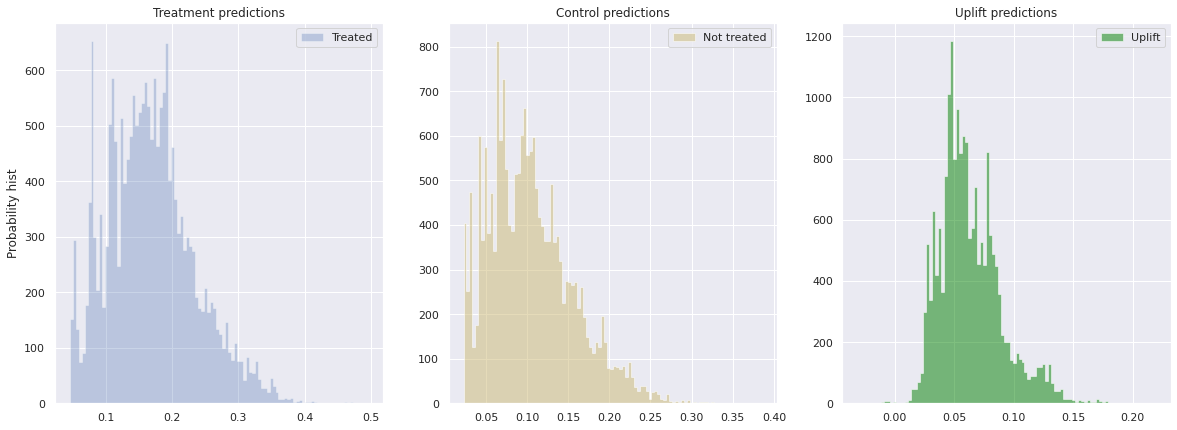

In [58]:
plot_uplift_preds(S_learn.trmnt_preds_, S_learn.ctrl_preds_)

Модель с трансформацией классов

In [53]:
cls_tr = ClassTransformation(estimator= CatBoostClassifier(iterations = 30, cat_features= cat_cols, random_state= 42, silent= True))

In [54]:
cls_tr.fit(X_train, y_train, t_train)

ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7ff7184508d0>)

In [55]:
y_ct_pred = cls_tr.predict(X_test)

In [59]:
# оцениваем результативность модели
score_10 = uplift_at_k(y_true = y_test, 
                       uplift = y_ct_pred,
                       treatment = t_test, 
                       strategy = 'overall',
                       k = 0.1) # расчет для 10 квантили
score_10

0.09431616001224391

In [60]:
score_20 = uplift_at_k(y_true = y_test, 
                       uplift = y_ct_pred,
                       treatment = t_test, 
                       strategy = 'overall',
                       k = 0.2) # расчет для 20 квантили
score_20

0.08628269497834715

In [61]:
# запишем результат
score_tab['uplift@10'].loc['ClassTransformation'] = score_10
score_tab['uplift@20'].loc['ClassTransformation'] = score_20
score_tab

,uplift@10,uplift@20
S-learner,0.086735,0.064475
ClassTransformation,0.094316,0.086283
TwoModels,NaN,NaN


Две независимых модели

In [66]:
two_mod = TwoModels(estimator_trmnt= CatBoostClassifier(iterations = 30, cat_features= cat_cols, random_state= 42, silent= True),
                     estimator_ctrl= CatBoostClassifier(iterations = 30, cat_features= cat_cols, random_state= 42, silent= True),
                    method = 'vanilla')

In [72]:
two_mod.fit(X_train.values, y_train.values, t_train.values)

IndexError: ignored

In [70]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_cols),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_cols),
    method='vanilla'  # независимые модели 
)

Опять не летит...

In [71]:
tm.fit(X_train, y_train, t_train)

CatBoostError: ignored

### Задание 6

In [76]:
df_test = X_test.copy() 

In [77]:
df_test['y_uplift'] = y_sm_pred

In [78]:
df_test['conversion'] = y_test

In [79]:
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,y_uplift,conversion
7304,4,84.41,0,1,Urban,1,Web,0.060868,0
12328,1,396.20,1,0,Urban,0,Web,0.085274,0
6473,1,105.95,0,1,Urban,0,Web,0.067817,0
35150,2,597.52,1,1,Urban,1,Phone,0.126073,1
19284,9,320.21,0,1,Urban,1,Multichannel,0.039645,0


In [81]:
df_test = df_test.sort_values(by='y_uplift', ascending=False)
df_test.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,y_uplift,conversion
51323,12,1033.92,1,1,Urban,1,Phone,0.219252,0
47284,12,389.67,0,1,Urban,0,Phone,0.214882,0
53324,12,392.87,0,1,Urban,0,Phone,0.214882,0
45560,12,793.35,1,1,Urban,1,Phone,0.210006,0
2833,12,475.00,0,1,Urban,0,Phone,0.198830,0
34279,9,204.00,1,1,Rural,1,Web,0.196771,0
10329,12,435.15,1,1,Urban,0,Phone,0.193605,1
5931,4,227.78,1,1,Rural,1,Phone,0.188938,0
35102,5,258.86,1,1,Rural,1,Phone,0.181670,0
38313,1,245.94,1,1,Surburban,1,Web,0.177659,0


In [89]:
df_test['deciles'] = pd.qcut(df_test['y_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,y_uplift,conversion,deciles
51323,12,1033.92,1,1,Urban,1,Phone,0.219252,0,9
47284,12,389.67,0,1,Urban,0,Phone,0.214882,0,9
53324,12,392.87,0,1,Urban,0,Phone,0.214882,0,9
45560,12,793.35,1,1,Urban,1,Phone,0.210006,0,9
2833,12,475.00,0,1,Urban,0,Phone,0.198830,0,9


In [93]:
d_tab = df_test[['deciles', 'conversion']].groupby(by = 'deciles').mean()
d_tab.columns = ['Конверсия']
d_tab.index.name = 'Номер дециля'
d_tab

,Конверсия
Номер дециля,
0,0.099066
1,0.112962
2,0.113030
3,0.122078
4,0.149269
5,0.166059
6,0.164938
7,0.150078
8,0.170068
